In [1]:
%run ../Environment/environment.ipynb

e:\Studienarbeit_GitHub\Studienarbeit\Agents
Notebook ausgeführt


# 1. Bibliotheken importieren

In [2]:
from stable_baselines3 import PPO

# 2. Seed setzen

In [3]:
seed = 42
SEED  = seed % (2**32 - 1)
print(f"SEED: {SEED}")

SEED: 42


# 3. Daten einlesen

In [4]:
# -------------------------------
# CSV Datem einlesen
# -------------------------------
train_data = pd.read_csv("../Transform_data/stand_data/2023-2018_stand_data.csv")
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv("../Transform_data/stand_data/2025-2024_stand_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

if(train_data is not None and test_data is not None):
    print("Daten erfolgreich eingelesen")

Daten erfolgreich eingelesen


# 4. RL Modell laden

In [5]:
A2C_model = PPO.load("A2C/a2c_trading_model.zip")
#DQN_model = PPO.load("DQN/dqn_trading_model.zip")
PPO_model = PPO.load("PPO/PPO_Model_Without_200K.zip")

model = PPO_model

# 5. Umgebungen erstellen

In [6]:
train_env = TradingEnv(
        data=train_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../Transform_data/scaler.pkl",
        default_seed=SEED
    )

Seed in the environment: 42


In [7]:
test_env = TradingEnv(
        data=test_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../Transform_data/scaler.pkl",
        default_seed=SEED
    )

Seed in the environment: 42


# 6. Hilfsfunktion für Performance Auswertung

In [8]:
def simulate_episode(env, model, seed=42, render_mode='human', print_preview=True):
    """
    Führt eine Episode in der angegebenen Umgebung mit dem gegebenen Modell aus.

    Parameter:
    - env: Die Umgebung (z. B. train_env, test_env, random_env)
    - model: Das trainierte RL-Modell mit .predict()-Methode
    - seed (int): Seed für den Reset der Umgebung
    - render_mode (str): Wie die Umgebung gerendert werden soll (z. B. 'human')
    - print_preview (bool): Gibt die ersten 200 Aktionen aus, wenn True

    Rückgabewert:
    - action_list (List[int]): Liste aller gewählten Aktionen in der Episode
    - observation_list (List[np.ndarray]): Liste aller Beobachtungsfenster
    """
    obs, info = env.reset(seed=seed)
    done = False
    action_list = []
    observation_list = []

    while not done:
        observation_list.append(obs.copy())  # wichtig: Kopie speichern!
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)  # falls notwendig
        obs, reward, done, truncated, info = env.step(action)
        action_list.append(action)

    env.render(mode=render_mode)

    if print_preview:
        print("Erste 200 Aktionen:", action_list[:200])

    return action_list, observation_list

# 7. Performance auf gesehenen Daten

Seed in the environment: 42


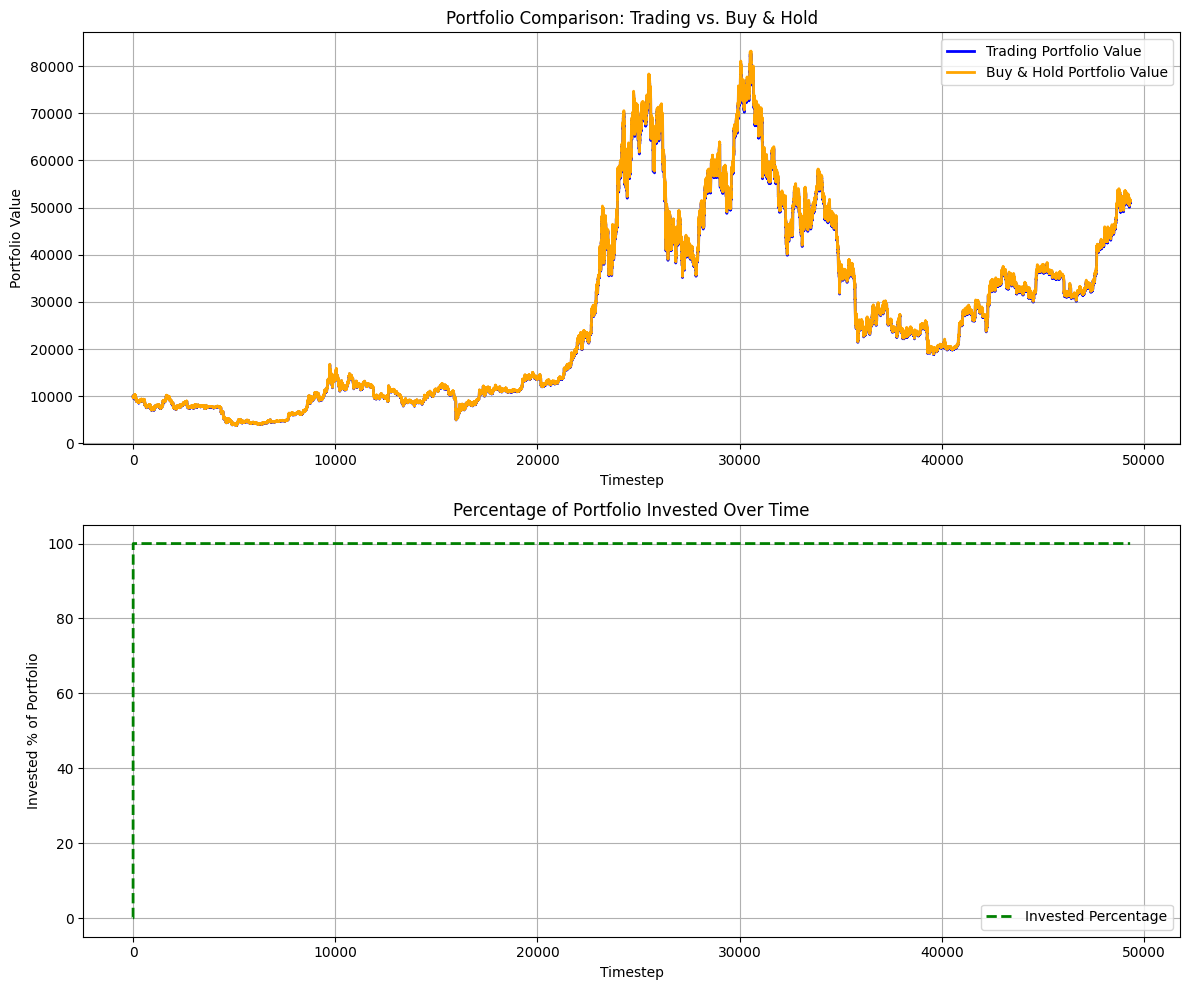

Erste 200 Aktionen: [8, 8, 8, 4, 5, 4, 3, 3, 0, 0, 0, 4, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [9]:
train_actions, train_observations = simulate_episode(train_env, model, seed=SEED)

# 8. Performance auf ungesehenen Daten

Seed in the environment: 42


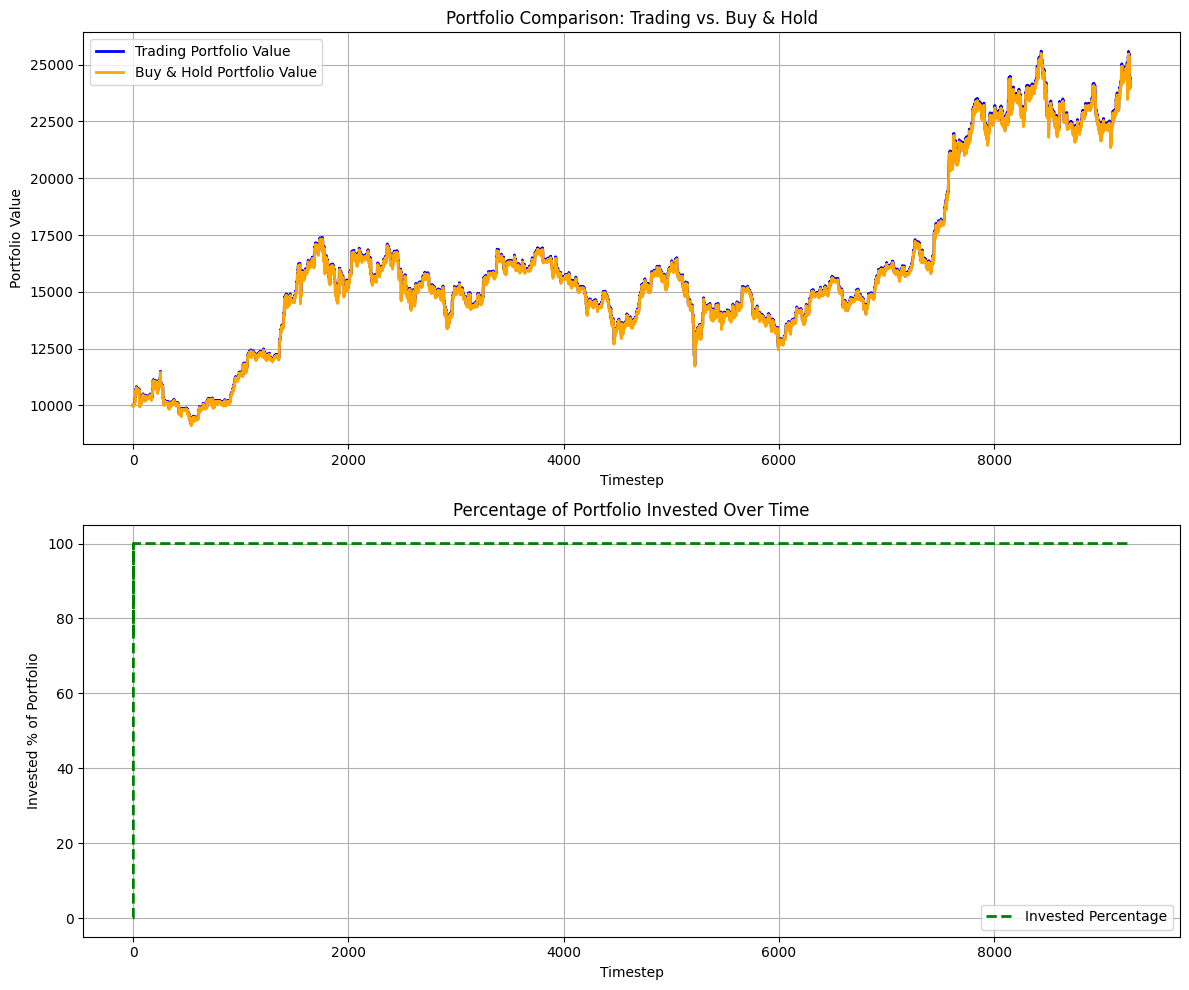

Erste 200 Aktionen: [8, 8, 8, 4, 5, 4, 3, 3, 0, 0, 0, 4, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [10]:
test_actions, test_observations = simulate_episode(test_env, model, seed=SEED)

# 9. Performance auf random Daten (zum Testen gleicher Aktionen)

# 9.1 Hilfsfunktion zur Erstellng Zufälliger Daten

Dabei werden die ungesehenen Testdaten in Blöcken der Größe 672 (4-Wochen) zufällig sortiert.

In [11]:
import csv
import random

def shuffle_csv_blocks(input_file, output_file, block_size=672):
    # CSV einlesen
    with open(input_file, newline='', encoding='utf-8') as csvfile:
        reader = list(csv.reader(csvfile))
        header = reader[0]
        data = reader[1:]

    # Blöcke erzeugen
    blocks = [data[i:i + block_size] for i in range(0, len(data), block_size)]

    # Blöcke zufällig mischen
    random.shuffle(blocks)

    # Neue Datenliste erstellen
    shuffled_data = [row for block in blocks for row in block]

    # In neue CSV-Datei schreiben
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)  # Kopfzeile wieder einfügen
        writer.writerows(shuffled_data)

# Beispielaufruf:
shuffle_csv_blocks("../Transform_data/stand_data/2025-2024_stand_data.csv", '../Transform_data/random_test_data.csv')

In [12]:
import pandas as pd

def compare_actionlists(list1, list2):
    """
    Vergleicht zwei Listen bis zur kürzeren Länge und gibt alle Unterschiede als DataFrame zurück.
    Gibt bei ungleicher Länge eine kurze Info aus.

    Rückgabewert:
    - Pandas DataFrame mit Spalten: 'Index', 'List1', 'List2'
    """
    min_len = min(len(list1), len(list2))
    differences = []

    for i in range(min_len):
        if list1[i] != list2[i]:
            differences.append({"Index": i, "List1": list1[i], "List2": list2[i]})

    if len(list1) != len(list2):
        print(f"⚠️ Unterschiedliche Längen: List1 = {len(list1)}, List2 = {len(list2)}")
    
    if differences:
        print(f"❌ {len(differences)} Unterschiede innerhalb der ersten {min_len} Elemente gefunden.")
    else:
        print("✅ Die beiden Listen sind in den ersten", min_len, "Elementen identisch.")
    
    return pd.DataFrame(differences)

In [13]:
import numpy as np

def compare_observations(obs_list_1, obs_list_2, tolerance=1e-6):
    """
    Vergleicht zwei Listen von Beobachtungen (np.ndarrays) und berechnet,
    wie viele der Beobachtungen exakt bzw. nahezu gleich sind.

    Parameter:
    - obs_list_1, obs_list_2: Zwei Listen von Beobachtungsarrays
    - tolerance: Zulässige numerische Abweichung für Gleichheit (float)

    Rückgabe:
    - matching_ratio: Anteil der übereinstimmenden Beobachtungen (0.0–1.0)
    """
    min_len = min(len(obs_list_1), len(obs_list_2))
    match_count = 0
    mismatch_indices = []

    for i in range(min_len):
        if obs_list_1[i].shape != obs_list_2[i].shape:
            mismatch_indices.append(i)
            continue

        if np.allclose(obs_list_1[i], obs_list_2[i], atol=tolerance):
            match_count += 1
        else:
            mismatch_indices.append(i)

    matching_ratio = match_count / min_len
    print(f"{match_count} von {min_len} Beobachtungen sind gleich ({matching_ratio*100:.2f} %)")
    if mismatch_indices:
        print(f"Unterschied bei Indizes: {mismatch_indices[:10]}{' ...' if len(mismatch_indices) > 10 else ''}")

    return matching_ratio

In [14]:
test_data = pd.read_csv("../Transform_data/random_test_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

random_env = TradingEnv(
        data=test_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../Transform_data/scaler.pkl",
        default_seed=SEED
    )

Seed in the environment: 42


Seed in the environment: 42


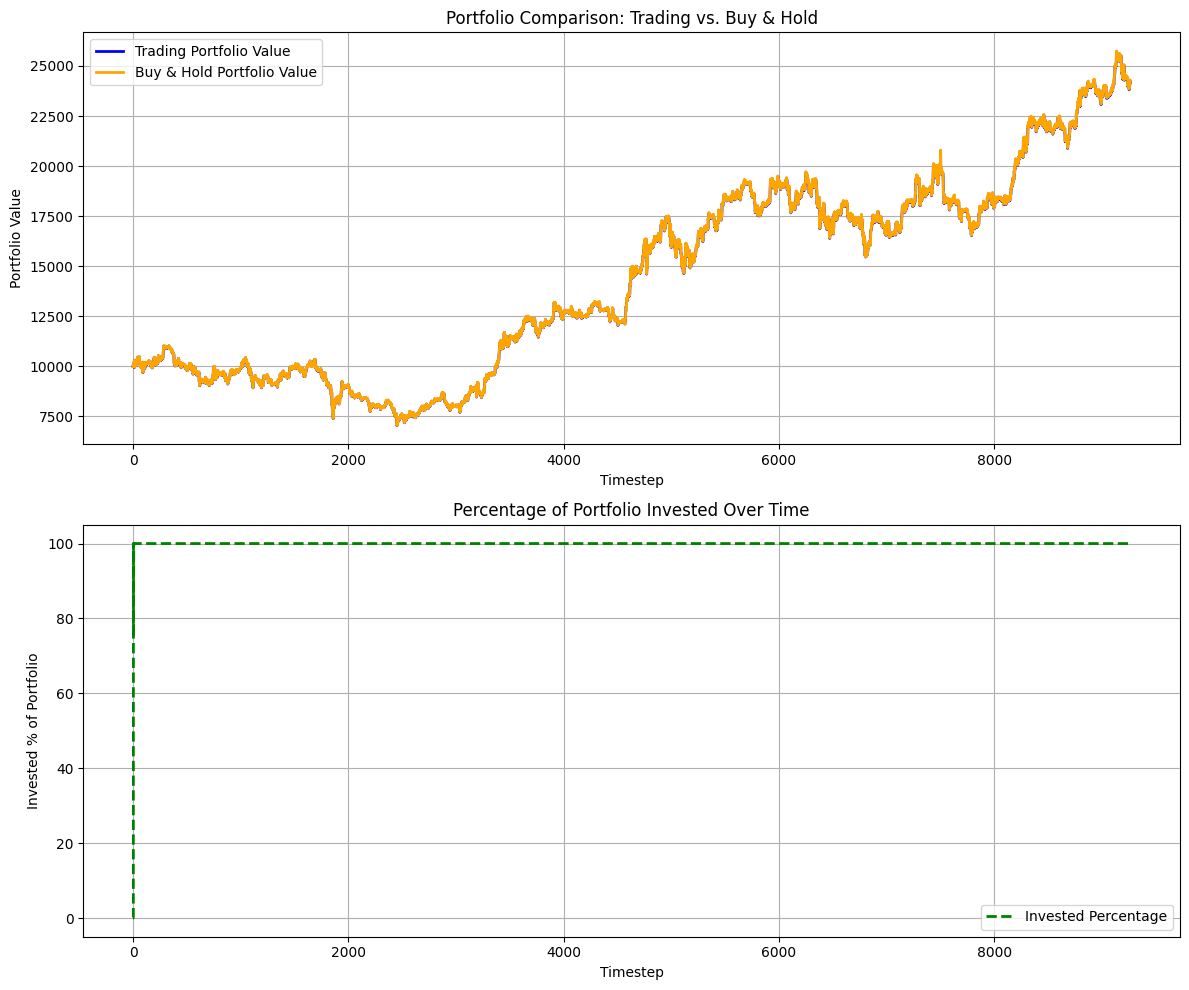

Erste 200 Aktionen: [8, 8, 8, 4, 5, 4, 3, 3, 0, 0, 0, 4, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [15]:
random_actions, random_observations = simulate_episode(random_env, model, seed=SEED)

In [16]:
compare_actionlists(train_actions, test_actions)

⚠️ Unterschiedliche Längen: List1 = 49312, List2 = 9264
✅ Die beiden Listen sind in den ersten 9264 Elementen identisch.


""


In [17]:
compare_actionlists(train_actions, random_actions)

⚠️ Unterschiedliche Längen: List1 = 49312, List2 = 9264
✅ Die beiden Listen sind in den ersten 9264 Elementen identisch.


""


In [18]:
compare_actionlists(test_actions, random_actions)

✅ Die beiden Listen sind in den ersten 9264 Elementen identisch.


""


In [19]:
compare_observations(train_observations, test_observations)

0 von 9264 Beobachtungen sind gleich (0.00 %)
Unterschied bei Indizes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...


0.0

In [20]:
compare_observations(train_observations, random_observations)

0 von 9264 Beobachtungen sind gleich (0.00 %)
Unterschied bei Indizes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...


0.0

In [21]:
compare_observations(test_observations, random_observations)

0 von 9264 Beobachtungen sind gleich (0.00 %)
Unterschied bei Indizes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...


0.0

Seed in the environment: 42


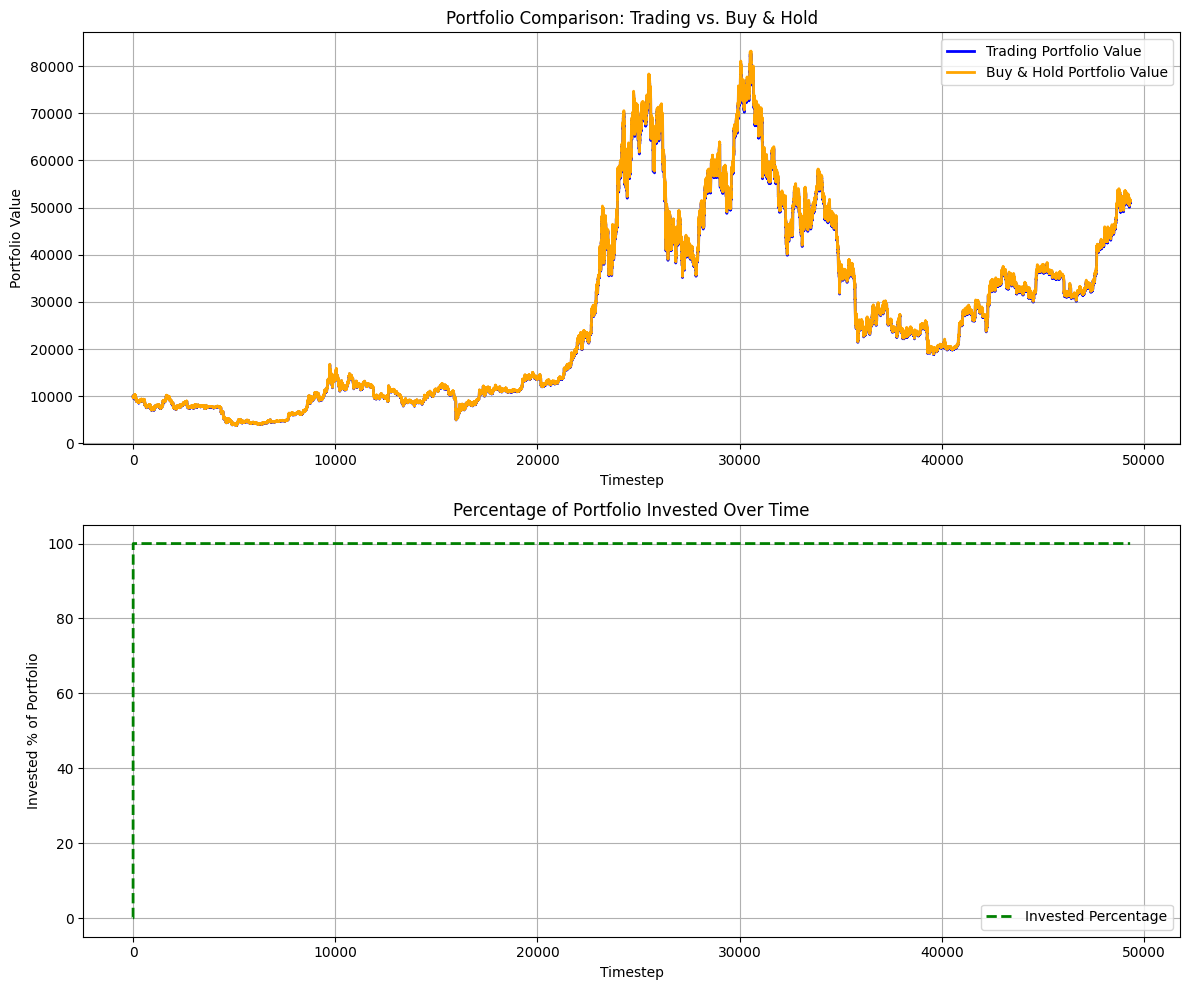

Erste 200 Aktionen: [8, 8, 8, 4, 5, 4, 3, 3, 0, 0, 0, 4, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Counter({3: 49293, 1: 7, 0: 5, 8: 3, 4: 3, 5: 1})


In [22]:
from collections import Counter
actions, _ = simulate_episode(train_env, model)
print(Counter(actions))

# ================================

Seed in the environment: 42


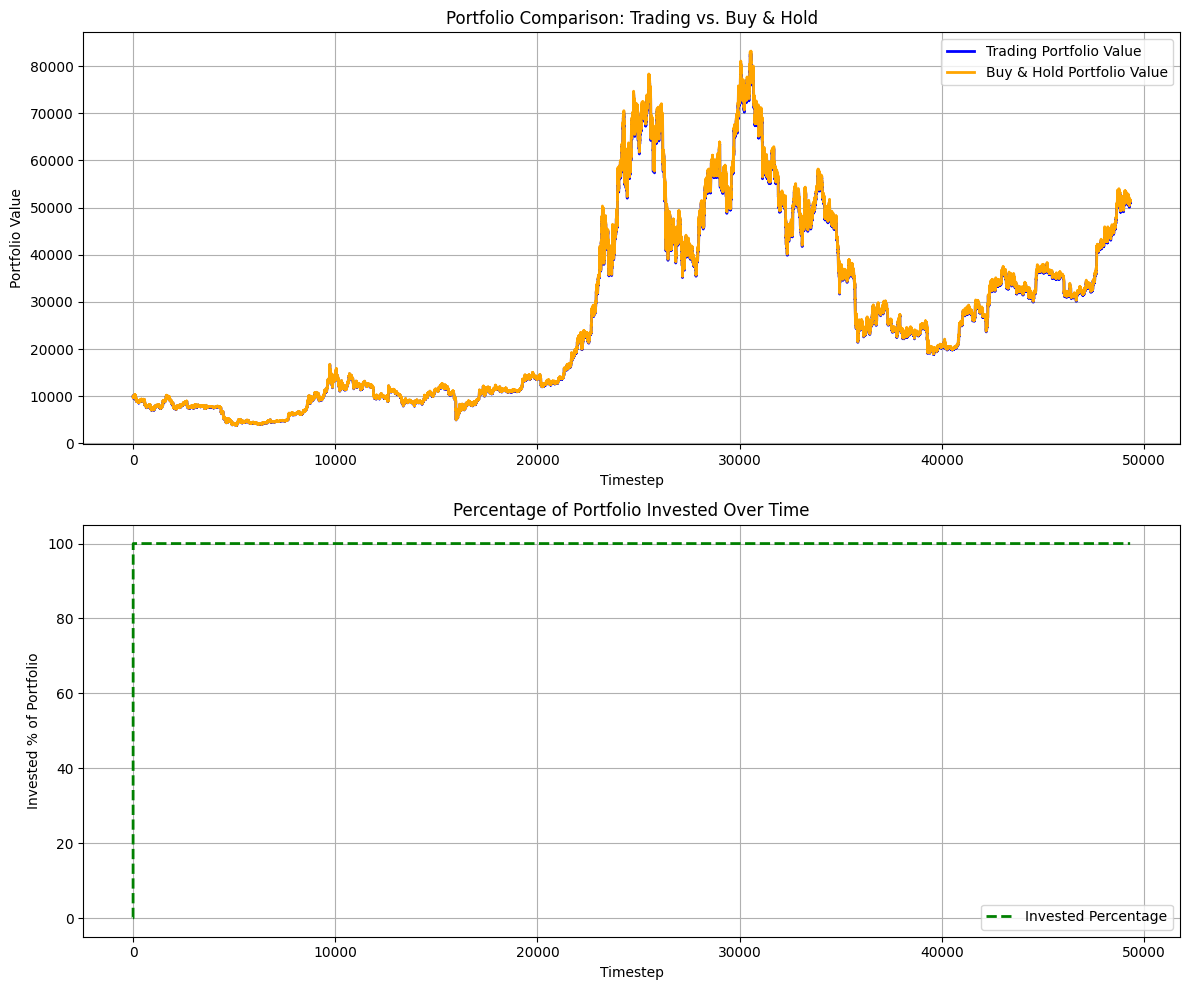

Erste 200 Aktionen: [8, 8, 8, 4, 5, 4, 3, 3, 0, 0, 0, 4, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [23]:
_, obs_list = simulate_episode(train_env, model)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity_sample(obs_array, sample_size=1000, seed=42):
    """
    Visualisiert die Ähnlichkeit eines zufälligen Ausschnitts von Beobachtungen.

    Parameters:
    - obs_array: 2D-Array mit flachen Beobachtungen (z. B. (n_steps, window_size*features))
    - sample_size: Anzahl der zu vergleichenden Beobachtungen
    - seed: für Reproduzierbarkeit
    """
    np.random.seed(seed)
    total = obs_array.shape[0]
    indices = np.random.choice(total, size=min(sample_size, total), replace=False)
    sampled_obs = obs_array[indices]

    similarity_matrix = cosine_similarity(sampled_obs)

    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label="Kosinus-Ähnlichkeit")
    plt.title(f"Ähnlichkeit zwischen {len(indices)} Beobachtungen")
    plt.xlabel("Index")
    plt.ylabel("Index")
    plt.show()


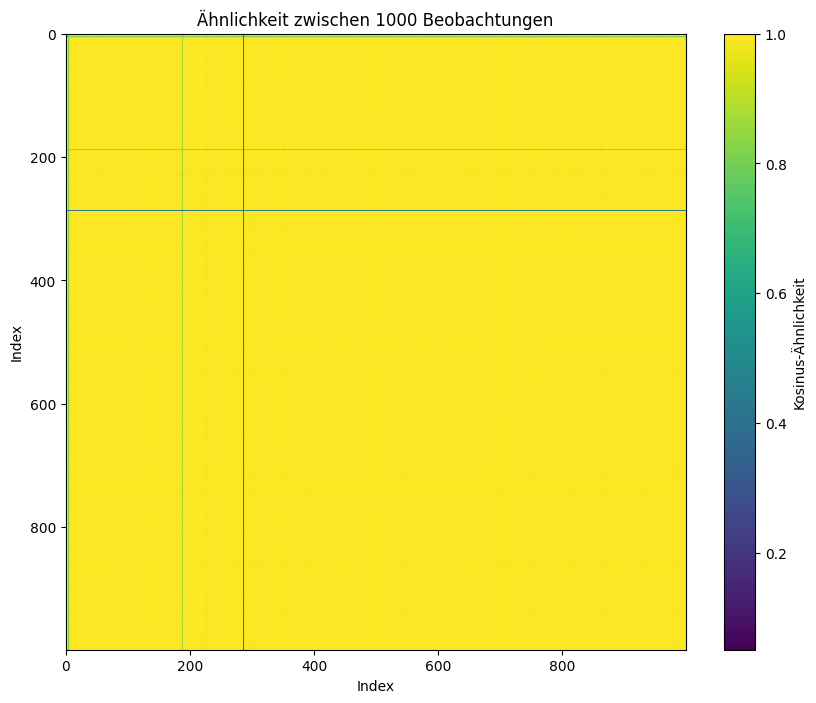

In [ ]:
obs_vectors = [obs.flatten() for obs in obs_list]
obs_array = np.array(obs_vectors)

plot_similarity_sample(obs_array, sample_size=5000)